# Detecting Credit Card Fraud With Autoencoder


Approach: Apply another flexible supervised method (lightgbm) then try to match the performance with autoencoder

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from tqdm import tqdm, tqdm_notebook


df_raw = pd.read_csv("data/creditcard.csv")

**Notes On Features**

**Time:** Number of seconds elapsed between this transaction and the first transaction in the dataset

**V1-V28:** may be result of a PCA Dimensionality reduction to protect user identities and sensitive features

**Amount:** Transaction amount

**Class:** 1 for fraudulent transactions, 0 otherwise

In [2]:
from sklearn.preprocessing import StandardScaler

df = df_raw
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [3]:
y = df['Class']
X = df.drop(['Class'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df_raw['Time'].index,df_raw['Time'])
plt.show()

<Figure size 640x480 with 1 Axes>

# Bayesian Optimization + Light GMB

In [6]:
import lightgbm as lgb
from skopt import gp_minimize

def objective(params):
    learning_rate = 10. ** params[0]
    num_leaves = params[1]
    n_estimators = params[2]

    lgbm = lgb.LGBMClassifier(
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=8,
        n_estimators=n_estimators,
        verbose=0,
    )

    return -np.mean(cross_val_score(lgbm, X_train, y_train, cv=10, scoring='f1'))

search_space = [(-5.0, 0.0), (2, 100), (2, 300)]

r = gp_minimize(objective, search_space, n_calls=10, random_state=42, n_jobs=-1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.0324
Function value obtained: -0.2982
Current minimum: -0.2982
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.4870
Function value obtained: -0.4865
Current minimum: -0.4865
Iteration No: 3 started. Evaluating function at random point.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.2656
Function value obtained: -0.0000
Current minimum: -0.4865
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.3889
Function value obtained: -0.8405
Current minimum: -0.8405
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 22.8810
Function value obtained: -0.0623
Current minimum: -0.8405
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.6747
Function value obtained: -0.6910
Current minimum: -0.8405
Iteration No: 7 started. Evaluating function at random point.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 19.6671
Function value obtained: -0.0000
Current minimum: -0.8405
Iteration No: 8 started. Evaluating function at random point.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.8708
Function value obtained: -0.0000
Current minimum: -0.8405
Iteration No: 9 started. Evaluating function at random point.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 19.6230
Function value obtained: -0.0000
Current minimum: -0.8405
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 27.5191
Function value obtained: -0.0817
Current minimum: -0.8405


[-1.745557635255735, 8, 217]

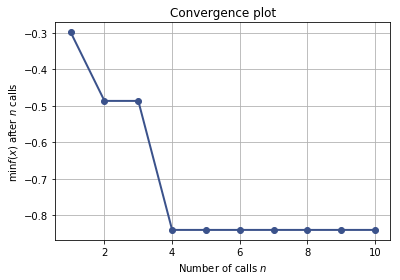

In [7]:
from skopt.plots import plot_convergence

plot_convergence(r)
best_params = r.x
best_params

In [8]:
final_lgbm = lgb.LGBMClassifier(num_leaves=best_params[1],
                        learning_rate= 10 ** best_params[0],
                        n_estimators=best_params[2],
                        verbose=1)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def final_model_test(X_all, y_all, X_test, y_test, model):
    
    model.fit(X_all, y_all)
    y_pred = model.predict(X_test)
    y_true = y_test
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()

    print("Model Results")

    print(conf)

    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    f1_score = 2*precision*recall/(precision + recall)

    print ('\n')
    print ("Accuracy:              %0.4f" % accuracy_score(y_pred,y_true))
    print ("Precision:              %0.4f" % precision)
    print ("Recall:                 %0.4f"% recall)
    print ("F1 Score:               %0.4f"% f1_score)

final_model_test(X_train, y_train, X_test, y_test, final_lgbm)

Model Results
[[56857     7]
 [   24    74]]


Accuracy:              0.9995
Precision:              0.9136
Recall:                 0.7551
F1 Score:               0.8268


# Autoencoder Experiment

In [10]:
#Split data by class for training/testing
X_autoencoder = df.query('Class == 0').drop(['Class'],axis=1)
Y_fraud = df.query('Class == 1').drop(['Class'],axis=1)

X_train_autoencoder = X_autoencoder.sample(frac=0.8,random_state=42)
X_test_autoencoder = X_autoencoder.drop(X_train_autoencoder.index)

In [11]:
from sklearn.metrics import mean_squared_error

#Renaming mse function to be consistent with literature
reconstruction_loss = mean_squared_error


In [12]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

epochs = 20
batch_size = 128
input_dim = X_train_autoencoder.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(loss='mean_squared_error', optimizer='adam')

autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=epochs, validation_data=(X_test_autoencoder, X_test_autoencoder))



Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 227452 samples, validate on 56863 samples
Epoch 1/20
227452/227452 [==============================] - 8s 35us/step - loss: 0.7430 - val_loss: 0.6898
Epoch 2/20
227452/227452 [==============================] - 8s 33us/step - loss: 0.6595 - val_loss: 0.6563
Epoch 3/20
227452/227452 [==============================] - 8s 34us/step - loss: 0.6478 - val_loss: 0.6509
Epoch 4/20
227452/227452 [==============================] - 8s 33us/step - loss: 0.6440 - val_loss: 0.6482
Epoch 5/20
227452/227452 [==============================] - 8s 33us/step - loss: 0.6418 - val_loss: 0.6457
Epoch 6/20
227452/227452 [==============================] - 8s 34us/step - loss: 0.6402 - val_loss: 0.6452
Epoch 7/20
227452/227452 [==============================] - 8s 34us/step - loss: 0.6387 - val_loss: 0.6436
Epoch 8/20
227452/227452 [==============================] - 8s 35us/step - loss: 0.6372 - val_loss: 0.6413
Epoch 9/20
227452/227452 [==============================] - 8s 36us/step - loss: 0.6349 - val

In [13]:
def predict(trained_model, set_threshold, input_data):
    predicted_array = trained_model.predict(input_data)
    instance_rec_loss = reconstruction_loss(input_data, predicted_array)
    
    if set_threshold == -1:
        return instance_rec_loss
    
    elif instance_rec_loss >= set_threshold:
        return 1
    
    else:
        return 0

In [14]:
from scipy import stats

rec_loss_dist_nonfraud = [predict(autoencoder,-1,np.array(X_autoencoder.iloc[n:n+1,:])) for n in tqdm_notebook(range(len(X_autoencoder)))]
rec_loss_dist_fraud = [predict(autoencoder,-1,np.array(Y_fraud.iloc[n:n+1,:])) for n in tqdm_notebook(range(len(Y_fraud)))]


In [15]:
print("Descriptive Statistics of Reconstruction Loss (ALL DATA) \n")

nonfraud_stats = stats.describe(rec_loss_dist_nonfraud)
print("\nNon-Fraudulent Data Stats:\n", nonfraud_stats)
fraud_stats = stats.describe(rec_loss_dist_fraud)
print("\nFraudulent Data Stats:\n", fraud_stats)


Descriptive Statistics of Reconstruction Loss (ALL DATA) 


Non-Fraudulent Data Stats:
 DescribeResult(nobs=284315, minmax=(0.02172820340202991, 1784.659718625746), mean=0.6281872949385339, variance=22.35959673715611, skewness=207.65428300736588, kurtosis=72541.27908277376)

Fraudulent Data Stats:
 DescribeResult(nobs=492, minmax=(0.09053274102064703, 270.9527012457573), mean=25.689544009881313, variance=1325.6655595714487, skewness=2.451565153705062, kurtosis=8.406893493510983)


In [16]:
#Initial threshold set to midpoint of the two means
threshold = nonfraud_stats.mean + abs(fraud_stats.mean - nonfraud_stats.mean)/2


In [17]:
y_pred = []

for index, row in tqdm_notebook(X_test.iterrows()):
     y_pred.append(predict(autoencoder, threshold, np.array([row.values])))
        

In [18]:
y_true = y_test
conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print("Model Results")
print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n Performance')
print ("Accuracy:              %0.4f" % accuracy_score(y_pred,y_true))
print ("Precision:              %0.4f" % precision)
print ("Recall:                 %0.4f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

Model Results
[[56664   200]
 [   61    37]]

 Performance
Accuracy:              0.9954
Precision:              0.1561
Recall:                 0.3776
F1 Score:               0.2209


## To Do

- Need to optimize neural network aka hyperparameter search
- Add an auc portion for selecting threshold